## SYMA : RecSys Challenge 2022

Authors:

- Victor Simonin
- Alexandre Lemonnier
- Sarah Gutierez
- Alexandre Poignant

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras import callbacks, layers, models, Sequential
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm

np.random.seed = 42
import warnings
warnings.filterwarnings("ignore")

# Loading data

`candidate_items.csv`: contains all the items available

In [9]:
candidates = pd.read_csv('./data/candidate_items.csv')
candidates

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


`item_features.csv`: contains all the features of each item

In [10]:
items = pd.read_csv('./data/item_features.csv')
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


`train_purchases.csv`: contains all the purchases that occurred at the end of a session.

In [11]:
train_purchases = pd.read_csv('data/train_purchases.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
train_purchases

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


`train_sessions.csv`: contains all the items viewed in a session for each session_id

In [12]:
train_sessions = pd.read_csv('data/train_sessions.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


`test_leaderboard_sessions`: contains the input sessions for the leader-board

In [13]:
test_leaderboard_sessions = pd.read_csv('./data/test_leaderboard_sessions.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Data analysis

Items are represented in a sparse format with the id of the feature and its value. We have no information on whether or not it is categorical or numerical, or the number of features.  
We want to explore them a little bit and find a compact representation.

First we want to know the coverage of each feature:

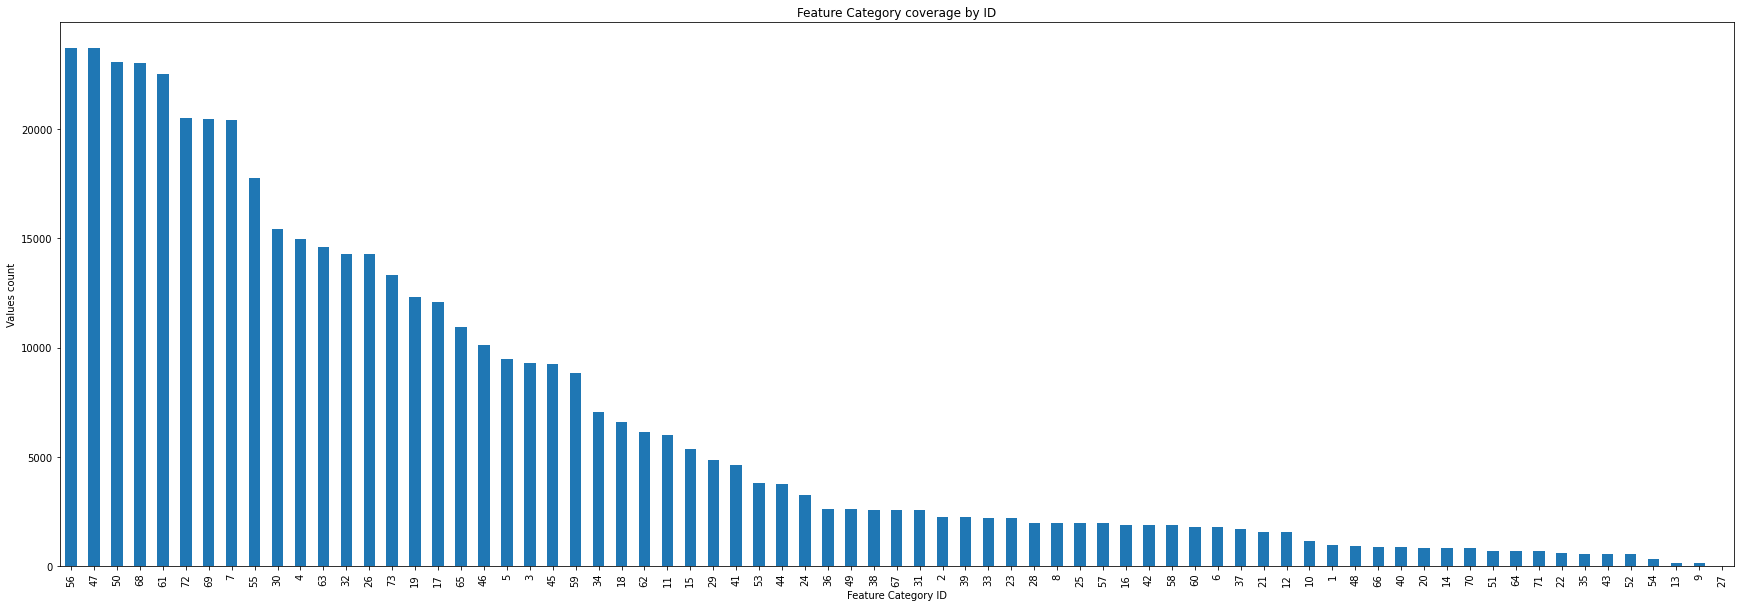

In [14]:
coverage = items['feature_category_id'].sort_values(ascending=False).value_counts(sort=True)
coverage.plot(
    kind='bar',
    figsize=(30, 10),
    xlabel='Feature Category ID',
    ylabel='Values count',
    title='Feature Category coverage by ID')

73 features is not that much, let's see how each of them look. Let's display the counts / min / max / std for each feature. 

In [15]:
items.drop(columns='item_id').groupby('feature_category_id', sort=False).describe()

feature_value_id                                        \
                               count        mean         std    min    25%   
feature_category_id                                                          
56                           23691.0  360.189861  107.438375    1.0  365.0   
62                            6148.0  639.005856  318.478435   15.0  801.0   
68                           23038.0  443.496050  230.800434   10.0  351.0   
33                            2221.0  328.501126  364.058791   36.0   36.0   
72                           20499.0  191.034392  218.286790    7.0   75.0   
...                              ...         ...         ...    ...    ...   
66                             877.0  869.124287   72.171785  264.0  886.0   
40                             877.0  594.037628  204.118748   49.0  449.0   
9                              137.0  223.635036   77.537171  175.0  175.0   
13                             137.0  580.554745  206.876701  252.0  252.0   
27                               1.0  423.000000         NaN  423.0  423.0   

                                          
                       50%    75%    max  
feature_category_id                       
56                   365.0  365.0  868.0  
62                   801.0  801.0  896.0  
68                   373.0  702.0  903.0  
33                    36.0  764.0  873.0  
72                    75.0  263.0  883.0  
...                    ...    ...    ...  
66                   886.0  886.0  886.0  
40                   717.0  717.0  717.0  
9                    190.0  190.0  369.0  
13                   698.0  698.0  905.0  
27                   423.0  423.0  423.0  

[73 rows x 8 columns]

We can see that the feature 27 is useless, because it has all the time the same value and appears only one time, we decided to remove it:

In [16]:
items.drop(items[items['feature_category_id'] == 27].index, inplace=True)
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


Let's see how the sessions are represented in the `train_sessions` dataset:

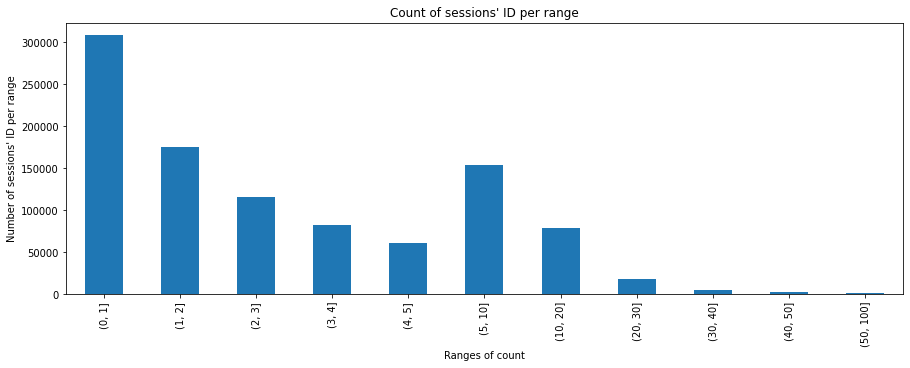

In [17]:
pd.cut(list(train_sessions['session_id'].value_counts()),
       bins=[0,1,2,3,4,5,10,20,30,40,50,100]).value_counts().plot(kind='bar',
                                                                      figsize=(15, 5), 
                                                                      xlabel='Ranges of count',
                                                                      ylabel='Number of sessions\' ID per range',
                                                                      title='Count of sessions\' ID per range')

We can see that most of the `session_id` in `train_sessions` dataset visit only one item.

Let's see some statistics about the `train_purchases` dataset:

In [18]:
train_purchases['session_id'].value_counts().describe()

count    1000000.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: session_id, dtype: float64

We can see that there is only one item bought by `session_id`

# Embeddings items

If 73 features is not a lot, it is still a big number. We have to preprocessed the data into a set of embeddings without sparse format because most ML algorithm do not handle sparse. We use TruncatedSVD from scikit-learn with n_components = 12 and compute embeddings for the items.

In [21]:
coo_mat = sparse.coo_matrix((items["feature_value_id"], (items["item_id"], items["feature_category_id"])))
coo_mat

<28144x74 sparse matrix of type '<class 'numpy.int64'>'
	with 471750 stored elements in COOrdinate format>

In [22]:
n_components = 12
svd = TruncatedSVD(n_components)
embeddings_items = pd.DataFrame(svd.fit_transform(coo_mat))
embeddings_items.shape

(28144, 12)

You now have a matrix of dimension (28144, n_components) representing the items.

In [23]:
embeddings_items

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,794.680184,377.343645,-303.561675,669.612877,487.114840,31.144402,179.057237,297.307245,-152.803444,-448.605775,-81.730306,45.701664
3,2387.218101,-924.921011,161.342831,-448.550062,-36.610165,-508.697766,-261.137511,140.711306,-136.590205,-86.517393,102.386931,-517.027842
4,2304.639154,-837.402436,194.342670,-143.934271,-183.789397,3.301773,190.618839,-170.646544,-157.029478,-63.522405,-372.210484,54.554827
...,...,...,...,...,...,...,...,...,...,...,...,...
28139,2496.719059,-681.709968,127.865505,94.363982,-141.323339,830.504477,-244.837771,-96.688715,366.755101,38.743710,-407.585112,-30.974585
28140,747.063373,532.023458,-1458.557348,-589.887963,-396.119652,6.416209,44.171603,-82.482474,-223.415349,-183.445819,79.941435,-78.387270
28141,2039.201872,-664.322600,27.056810,-712.698190,16.570348,17.024003,252.182731,-164.873547,-58.354355,-298.718251,-74.727222,-138.771576
28142,1472.569195,356.499023,-347.940107,38.524855,879.685994,493.896582,56.284722,12.013129,227.471718,-35.947892,-237.668555,-302.987776


We need to remove some object otherwise we could be out of memory.

In [24]:
del items, coo_mat, svd

# Embedding sessions

Sessions are defined by a series of items, we first want to see what they look like to be able to find a suitable representation for them.

We start by sampling the train_sessions dataframe to keep 10% of the data.

In [25]:
df_sessions = train_sessions.sample(frac=0.10)
df_sessions

,session_id,item_id,date
4581751,4288824,17648,2020-10-29 15:48:54.785
3598286,3363753,13500,2020-08-25 01:38:15.058
3561679,3329002,13169,2020-04-18 13:28:31.774
122222,114012,3460,2020-02-07 16:12:26.948
2058880,1924884,5995,2021-02-11 17:16:27.45
...,...,...,...
1771949,1656368,10545,2020-09-29 15:54:29.332
2263199,2115279,25383,2021-03-30 14:19:38.272
4170501,3902594,582,2020-09-20 18:24:25.201
4487158,4200167,15220,2020-11-27 22:19:50.357


Let's rank our `session_id` with their count of relative items:

In [26]:
sessions_ranks = df_sessions.groupby('session_id').agg(rank=('item_id', 'count'))
sessions_ranks

,rank
session_id,
3,1
19,4
24,5
31,4
49,1
...,...
4439953,1
4439986,1
4439990,1


In [27]:
df_sessions = df_sessions.join(sessions_ranks, on='session_id', rsuffix='_dup')
df_sessions

,session_id,item_id,date,rank
4581751,4288824,17648,2020-10-29 15:48:54.785,2
3598286,3363753,13500,2020-08-25 01:38:15.058,1
3561679,3329002,13169,2020-04-18 13:28:31.774,2
122222,114012,3460,2020-02-07 16:12:26.948,2
2058880,1924884,5995,2021-02-11 17:16:27.45,1
...,...,...,...,...
1771949,1656368,10545,2020-09-29 15:54:29.332,6
2263199,2115279,25383,2021-03-30 14:19:38.272,3
4170501,3902594,582,2020-09-20 18:24:25.201,5
4487158,4200167,15220,2020-11-27 22:19:50.357,2


We determine a threshold to contain completely 90% of the sessions. This is how we will compute the session representation.

Text(0.5, 1.0, 'Cumulative sum of sessions by rank')

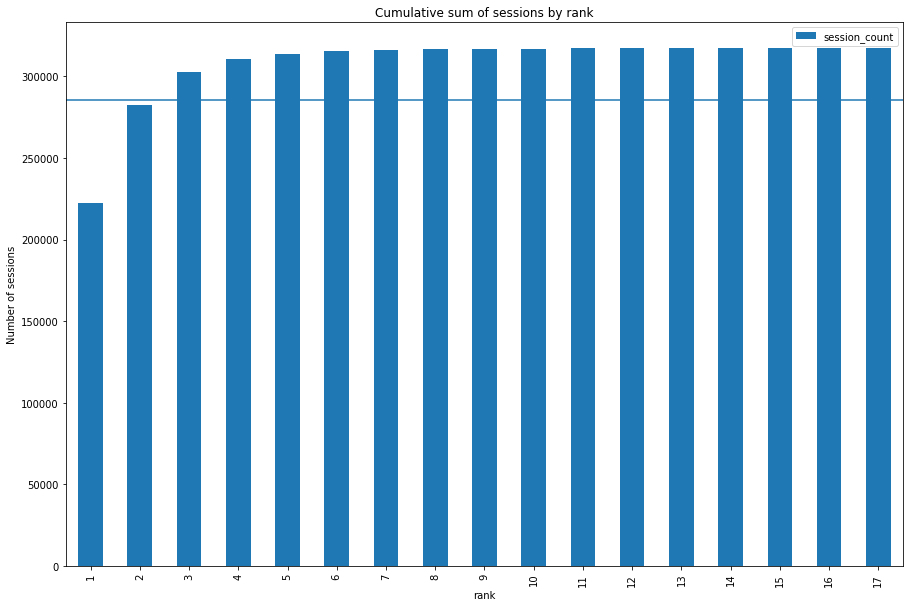

In [28]:
threshold = 0.90

sessions_ranks['session_id'] = sessions_ranks.index
count_by_rank = sessions_ranks.groupby('rank').agg(session_count=('session_id', 'count'))
count_by_rank['session_count'] = count_by_rank["session_count"].cumsum()

count_by_rank.plot(kind='bar', figsize=(15, 10))
plt.axhline(count_by_rank['session_count'].max() * threshold)
plt.ylabel('Number of sessions')
plt.title('Cumulative sum of sessions by rank')

We can see that 90% of the sessions are represented after the third rank, so we don't need to keep data with a rank higher than 3. That means we will only focus our prediction on maximum 3 items visited per session.

Let $k$ be the length we picked for our session, here 3.

In [ ]:
k = 3
df_sessions = df_sessions[df_sessions['rank'] <= k]
df_sessions

We vectorize our sessions by concatenating the embedding of the corresponding items.

In [30]:
df_sessions = df_sessions.drop(['date', 'rank'], axis=1) \
               .join(embeddings_items, on='item_id', rsuffix='_dup') \
               .set_index('session_id') \
               .sort_index()
df_sessions

,item_id,0,1,2,3,4,5,6,7,8,9,10,11
session_id,,,,,,,,,,,,,
3,9655,785.516809,562.549824,-1516.871374,-581.048863,-424.922590,151.052127,38.506199,-58.099957,-208.462583,-241.709609,144.815239,-85.920905
49,21358,875.337104,823.055448,-1889.698394,-842.999659,-375.554182,58.445531,-86.040701,25.513244,223.342970,256.734655,-127.694266,16.668487
77,13214,2304.851186,-848.621083,135.218537,-590.556145,2.537311,-279.529087,185.239318,-316.936315,-263.544111,-101.652518,-408.566685,251.305763
108,24454,2609.971233,-175.797406,182.683009,-292.547502,-100.759706,-400.569817,-500.182455,383.481493,219.057913,330.808998,56.453400,36.476316
108,2995,2706.083725,-118.950650,222.147111,-478.853845,119.343913,-272.485559,-143.708131,307.847384,227.485807,125.947137,-279.103602,-183.503368
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439986,12373,1486.565607,176.155268,-476.511983,1185.097522,56.574508,-204.247039,264.651250,18.557721,120.418607,-583.653997,183.995620,247.173390
4439990,17089,1387.757195,127.619007,-407.660460,1199.389220,7.869081,-237.981803,242.404558,-72.639137,103.742690,-511.555349,225.912050,163.113379
4439999,1299,876.551856,666.005869,-1826.477958,-768.100117,-476.467193,3.244378,45.248802,-118.317432,-287.514868,-173.312687,52.175002,-184.093181


In [31]:
columns = { f'<lambda_{i}>': i + 1 for i in range(k) }
columns

{'<lambda_0>': 1, '<lambda_1>': 2, '<lambda_2>': 3}

Here we retrieve the $k$ (here 3) embedding items features values of the session 

In [32]:
components = [i for i in range(n_components)]
df_sessions = df_sessions.groupby('session_id')[components].agg([
    lambda x: x.iloc[0] if len(x) > 0 else 0.,
    lambda x: x.iloc[1] if len(x) > 1 else 0.,
    lambda x: x.iloc[2] if len(x) > 2 else 0.,
]).rename(columns=columns)

df_sessions

0                              1                    \
                      1            2    3            1           2    3   
session_id                                                                
3            785.516809     0.000000  0.0   562.549824    0.000000  0.0   
49           875.337104     0.000000  0.0   823.055448    0.000000  0.0   
77          2304.851186     0.000000  0.0  -848.621083    0.000000  0.0   
108         2609.971233  2706.083725  0.0  -175.797406 -118.950650  0.0   
113         2079.428465     0.000000  0.0  1351.328776    0.000000  0.0   
...                 ...          ...  ...          ...         ...  ...   
4439953     1710.069605     0.000000  0.0   132.577601    0.000000  0.0   
4439986     1486.565607     0.000000  0.0   176.155268    0.000000  0.0   
4439990     1387.757195     0.000000  0.0   127.619007    0.000000  0.0   
4439999      876.551856     0.000000  0.0   666.005869    0.000000  0.0   
4440001     1469.600814  2116.262075  0.0   164.189636 -506.498846  0.0   

                     2                             3   ...   8           9   \
                      1           2    3            1  ...    3           1   
session_id                                             ...                    
3          -1516.871374    0.000000  0.0  -581.048863  ...  0.0 -241.709609   
49         -1889.698394    0.000000  0.0  -842.999659  ...  0.0  256.734655   
77           135.218537    0.000000  0.0  -590.556145  ...  0.0 -101.652518   
108          182.683009  222.147111  0.0  -292.547502  ...  0.0  330.808998   
113          216.092182    0.000000  0.0  1149.482717  ...  0.0  274.479992   
...                 ...         ...  ...          ...  ...  ...         ...   
4439953     -574.464958    0.000000  0.0  1303.906211  ...  0.0   18.008353   
4439986     -476.511983    0.000000  0.0  1185.097522  ...  0.0 -583.653997   
4439990     -407.660460    0.000000  0.0  1199.389220  ...  0.0 -511.555349   
4439999    -1826.477958    0.000000  0.0  -768.100117  ...  0.0 -173.312687   
4440001     -464.996727   72.519289  0.0  1183.359300  ...  0.0 -571.372301   

                                     10                           11  \
                     2    3           1           2    3           1   
session_id                                                             
3             0.000000  0.0  144.815239    0.000000  0.0  -85.920905   
49            0.000000  0.0 -127.694266    0.000000  0.0   16.668487   
77            0.000000  0.0 -408.566685    0.000000  0.0  251.305763   
108         125.947137  0.0   56.453400 -279.103602  0.0   36.476316   
113           0.000000  0.0 -391.358140    0.000000  0.0 -247.091444   
...                ...  ...         ...         ...  ...         ...   
4439953       0.000000  0.0 -313.880800    0.000000  0.0 -214.684637   
4439986       0.000000  0.0  183.995620    0.000000  0.0  247.173390   
4439990       0.000000  0.0  225.912050    0.000000  0.0  163.113379   
4439999       0.000000  0.0   52.175002    0.000000  0.0 -184.093181   
4440001    -211.213221  0.0  172.046934 -285.514293  0.0  188.599334   

                             
                     2    3  
session_id                   
3             0.000000  0.0  
49            0.000000  0.0  
77            0.000000  0.0  
108        -183.503368  0.0  
113           0.000000  0.0  
...                ...  ...  
4439953       0.000000  0.0  
4439986       0.000000  0.0  
4439990       0.000000  0.0  
4439999       0.000000  0.0  
4440001    -269.352614  0.0  

[302731 rows x 36 columns]

In [33]:
df_sessions.columns = df_sessions.columns.to_flat_index()
df_sessions

,"(0, 1)","(0, 2)","(0, 3)","(1, 1)","(1, 2)","(1, 3)","(2, 1)","(2, 2)","(2, 3)","(3, 1)",...,"(8, 3)","(9, 1)","(9, 2)","(9, 3)","(10, 1)","(10, 2)","(10, 3)","(11, 1)","(11, 2)","(11, 3)"
session_id,,,,,,,,,,,,,,,,,,,,,
3,785.516809,0.000000,0.0,562.549824,0.000000,0.0,-1516.871374,0.000000,0.0,-581.048863,...,0.0,-241.709609,0.000000,0.0,144.815239,0.000000,0.0,-85.920905,0.000000,0.0
49,875.337104,0.000000,0.0,823.055448,0.000000,0.0,-1889.698394,0.000000,0.0,-842.999659,...,0.0,256.734655,0.000000,0.0,-127.694266,0.000000,0.0,16.668487,0.000000,0.0
77,2304.851186,0.000000,0.0,-848.621083,0.000000,0.0,135.218537,0.000000,0.0,-590.556145,...,0.0,-101.652518,0.000000,0.0,-408.566685,0.000000,0.0,251.305763,0.000000,0.0
108,2609.971233,2706.083725,0.0,-175.797406,-118.950650,0.0,182.683009,222.147111,0.0,-292.547502,...,0.0,330.808998,125.947137,0.0,56.453400,-279.103602,0.0,36.476316,-183.503368,0.0
113,2079.428465,0.000000,0.0,1351.328776,0.000000,0.0,216.092182,0.000000,0.0,1149.482717,...,0.0,274.479992,0.000000,0.0,-391.358140,0.000000,0.0,-247.091444,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439953,1710.069605,0.000000,0.0,132.577601,0.000000,0.0,-574.464958,0.000000,0.0,1303.906211,...,0.0,18.008353,0.000000,0.0,-313.880800,0.000000,0.0,-214.684637,0.000000,0.0
4439986,1486.565607,0.000000,0.0,176.155268,0.000000,0.0,-476.511983,0.000000,0.0,1185.097522,...,0.0,-583.653997,0.000000,0.0,183.995620,0.000000,0.0,247.173390,0.000000,0.0
4439990,1387.757195,0.000000,0.0,127.619007,0.000000,0.0,-407.660460,0.000000,0.0,1199.389220,...,0.0,-511.555349,0.000000,0.0,225.912050,0.000000,0.0,163.113379,0.000000,0.0


In [34]:
del train_sessions, sessions_ranks

# Embedding purchases
Purchases are one item, so we simply use their embedding. However, we also need to add negative samples so that our model not only learn on positives (One class SVM can do this, but those models are not known to generalize well...). In order to generate negative samples, we shuffle the item_id columns of 4 copies of the purchase array. The original values have a label 1, the copies that have been shuffled have a value of 0.

We drop the `date` column because we don't need it in our studies

In [35]:
train_purchases.drop('date', axis=1, inplace=True)

In [36]:
negative_samples = pd.concat([train_purchases.copy() for _ in range(4)]).reset_index(drop=True)
negative_samples['item_id'] = np.random.permutation(negative_samples['item_id'])
negative_samples['label'] = 0

positive_samples = train_purchases.copy()
positive_samples['label'] = 1

embedding_purchases = pd.concat([positive_samples, negative_samples]).reset_index(drop=True)
embedding_purchases = embedding_purchases.merge(embeddings_items, left_on='item_id', right_index=True)
embedding_purchases.drop('item_id', axis=1, inplace=True)
embedding_purchases

,session_id,label,0,1,2,3,4,5,6,7,8,9,10,11
0,3,1,719.984006,528.835203,-1468.389289,-590.228426,-461.644624,142.299887,11.526363,-86.036871,-204.320370,-149.995054,164.249757,-137.386188
81109,362500,1,719.984006,528.835203,-1468.389289,-590.228426,-461.644624,142.299887,11.526363,-86.036871,-204.320370,-149.995054,164.249757,-137.386188
156247,695904,1,719.984006,528.835203,-1468.389289,-590.228426,-461.644624,142.299887,11.526363,-86.036871,-204.320370,-149.995054,164.249757,-137.386188
208983,931085,1,719.984006,528.835203,-1468.389289,-590.228426,-461.644624,142.299887,11.526363,-86.036871,-204.320370,-149.995054,164.249757,-137.386188
295572,1315209,1,719.984006,528.835203,-1468.389289,-590.228426,-461.644624,142.299887,11.526363,-86.036871,-204.320370,-149.995054,164.249757,-137.386188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998998,4435589,1,900.453529,743.852970,-1572.398617,-649.873816,-118.221297,26.048154,-11.074122,96.966977,141.419105,64.745859,-178.146974,-154.644221
2722244,3206729,0,900.453529,743.852970,-1572.398617,-649.873816,-118.221297,26.048154,-11.074122,96.966977,141.419105,64.745859,-178.146974,-154.644221
2781106,3468021,0,900.453529,743.852970,-1572.398617,-649.873816,-118.221297,26.048154,-11.074122,96.966977,141.419105,64.745859,-178.146974,-154.644221
2871172,3868769,0,900.453529,743.852970,-1572.398617,-649.873816,-118.221297,26.048154,-11.074122,96.966977,141.419105,64.745859,-178.146974,-154.644221


In [37]:
del train_purchases, negative_samples, positive_samples

# Merge everything

We merge the whole dataset together to fit a model. For each session we concatenate:
* The history of the user
* The purchase embedding, with the label

We will have our training set!

In [38]:
df_merged = df_sessions.merge(embedding_purchases, on='session_id', how='inner')
df_merged.head()

,session_id,"(0, 1)","(0, 2)","(0, 3)","(1, 1)","(1, 2)","(1, 3)","(2, 1)","(2, 2)","(2, 3)",...,2,3,4,5,6,7,8,9,10,11
0,3,785.516809,0.0,0.0,562.549824,0.0,0.0,-1516.871374,0.0,0.0,...,-1468.389289,-590.228426,-461.644624,142.299887,11.526363,-86.036871,-204.320370,-149.995054,164.249757,-137.386188
1,3,785.516809,0.0,0.0,562.549824,0.0,0.0,-1516.871374,0.0,0.0,...,-511.294643,1208.107417,64.775497,-161.005835,176.320027,95.157751,540.300895,-232.909747,83.636939,276.173921
2,3,785.516809,0.0,0.0,562.549824,0.0,0.0,-1516.871374,0.0,0.0,...,-309.238668,1048.600498,-335.537733,243.755953,6.284514,642.325885,-452.547116,-178.998754,-120.074355,19.029772
3,3,785.516809,0.0,0.0,562.549824,0.0,0.0,-1516.871374,0.0,0.0,...,600.898830,-560.408189,175.931660,-306.190831,667.710580,-45.456134,-138.962179,182.429758,38.613970,-336.486682
4,3,785.516809,0.0,0.0,562.549824,0.0,0.0,-1516.871374,0.0,0.0,...,-20.926733,280.986330,-141.633401,-1.891979,-154.364450,-781.485353,470.831032,-377.451128,104.780393,-233.246758


In [39]:
df_merged.columns

Index(['session_id',       (0, 1),       (0, 2),       (0, 3),       (1, 1),
             (1, 2),       (1, 3),       (2, 1),       (2, 2),       (2, 3),
             (3, 1),       (3, 2),       (3, 3),       (4, 1),       (4, 2),
             (4, 3),       (5, 1),       (5, 2),       (5, 3),       (6, 1),
             (6, 2),       (6, 3),       (7, 1),       (7, 2),       (7, 3),
             (8, 1),       (8, 2),       (8, 3),       (9, 1),       (9, 2),
             (9, 3),      (10, 1),      (10, 2),      (10, 3),      (11, 1),
            (11, 2),      (11, 3),      'label',            0,            1,
                  2,            3,            4,            5,            6,
                  7,            8,            9,           10,           11],
      dtype='object')

In [44]:
X = df_merged.drop(['label', 'session_id'], axis=1)
y = df_merged['label']

In [45]:
X = X.reindex(columns = pd.Index([
        (0,1),(1,1),(2,1),(3,1),(4,1),(5,1),(6,1),(7,1),(8,1),(9,1),(10,1),(11,1),
        (0,2),(1,2),(2,2),(3,2),(4,2),(5,2),(6,2),(7,2),(8,2),(9,2),(10,2),(11,2),
        (0,3),(1,3),(2,3),(3,3),(4,3),(5,3),(6,3),(7,3),(8,3),(9,3),(10,3),(11,3),
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
    ]))

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [47]:
del embedding_purchases

# Recommend items

We pre-compute the embeddings items for the candidates and we stock the embeddings in a dictionnary.

In [48]:
candidates_embeddings = {}
for candidate in tqdm(candidates['item_id']):
    candidates_embeddings[candidate] = embeddings_items.iloc[candidate]

embeddings_items_dict = {}
for item in tqdm(embeddings_items.index):
    embeddings_items_dict[item] = embeddings_items.iloc[item].values

100%|██████████| 28144/28144 [00:01<00:00, 18254.44it/s]


In [49]:
def recommend_100_items(model, sessions_items, isRNN=False):
    
    # Get the embedding items features of the training dataset
    s_embedding_items = X_train.copy()[0:0]
    s_embedding_items.loc[0] = 0.
    for i, item in enumerate(sessions_items):
        s_embedding_items.at[0, [(j, i + 1) for j in range(n_components)]] = embeddings_items_dict[item]

    items_proba = {}
    # For each candidate item, recover its embedding and predict the probability of being bought by the session's user.
    for candidate in tqdm(candidates['item_id']):
        if candidate in sessions_items:
            continue
        s_embedding_items.at[0, [i for i in range(n_components)]] = candidates_embeddings[candidate]
        if not isRNN:
            proba = model.predict_proba(s_embedding_items)[0][0]
        else:
            proba = model.predict(s_embedding_items.values.reshape(-1, k+1, n_components))
        items_proba[candidate] = proba

    # Sort the probability of each items and recover the best 100.
    recommended_items = sorted(items_proba.items(), key=lambda d: d[1], reverse=True)[:100]
    return np.array(recommended_items)[:, 0].astype('int32')

In [50]:
del df_merged, df_sessions, X, y

# Logistic Regression

We can now directly pass the merged dataset to a LogisticRegression. For the testing part, we perform our prediction on all candidates and pick the hundred ones that have the highest results.

In [51]:
l_regr = LogisticRegression()
l_regr.fit(X_train, y_train)
l_regr.score(X_test, y_test)

0.7999677601780061

We can see that we have an accuracy of 79,99% on our test dataset with this model.

In [52]:
# Example
session_items = [5, 100, 420]
recommend_100_items(l_regr, session_items)

100%|██████████| 4990/4990 [00:14<00:00, 349.90it/s]


array([ 2222, 11006, 24067, 17454, 22931, 22441, 20165,  5377, 22146,
       22178, 14192,  8178,  7244, 15087, 24881,  3440, 12127,  9564,
       20437,  2429,  2967,  2256,  2831,  5233, 24123,   603,  3019,
       19115, 27974, 19458, 13973, 24005,   720, 19987, 17065, 16045,
       16631, 21185, 11515, 19099,   808, 27754,  1968,  9411, 11328,
       23889, 24814,   652, 16776,  9562,  3298, 10496,   175, 25118,
       18809, 16139, 27800,  5288, 14214, 19297, 21313, 25083, 21241,
       10625,  9915, 27731, 27702, 18183, 25184, 13273,   502, 26985,
       21116, 26622, 16427, 21919, 11689, 23286, 16145,  1036, 13250,
        4113,   398, 14240, 26796, 21998, 13717,  1784, 23986, 16863,
       14282, 15521, 27183, 23769, 15246, 17800, 16003,  6871, 19955,
       15177], dtype=int32)

# RNN

Now, let's try to have a basic RNN running on this dataset.

In [54]:
input_shape = (k+1, 12)

rnn = Sequential()
rnn.add(layers.Masking(mask_value=0, input_shape=input_shape))
rnn.add(layers.LSTM(100,return_sequences=False))
rnn.add(layers.Dense(k, activation='softmax'))

rnn.compile("adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 4, 12)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               45200     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 45,503
Trainable params: 45,503
Non-trainable params: 0
_________________________________________________________________


In [55]:
checkpoint = callbacks.ModelCheckpoint(filepath="model_checkpoint",
                                       monitor ="val_accuracy",
                                       save_best_only = True,
                                       mode='max')

In [ ]:
history = rnn.fit(X_train.values.reshape(-1, k+1, n_components),
                  y_train,
                  validation_split=0.2,
                  epochs=3,
                  batch_size=64,
                  callbacks=[checkpoint])
rnn = models.load_model('model_checkpoint')

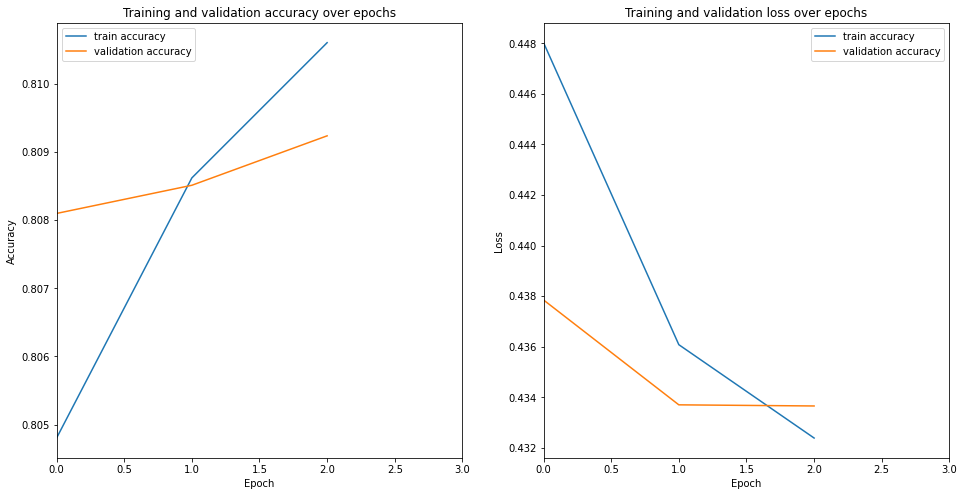

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim([0, 3])
plt.legend(['train accuracy', 'validation accuracy'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim([0, 3])
plt.legend(['train accuracy', 'validation accuracy'], loc='best')
plt.show()

In [ ]:
rnn.evaluate(X_test.values.reshape(-1, k+1, n_components), y_test)

11847/11847 [==============================] - 224s 19ms/step - loss: 0.4335 - accuracy: 0.8109


[0.43348705768585205, 0.8108944296836853]

We can see that we have an accuracy of almost 81% with this basic RNN.

In [ ]:
# Example
session_items = [5, 100, 420]
recommend_100_items(rnn, session_items, isRNN=True)

# Try to reduce the features' number

Let's restart all and reducing the number of features used. Here, we will use the 15 most used features' category of the items, and remove all data with the other features.

In [62]:
items = pd.read_csv('./data/item_features.csv')
train_sessions = pd.read_csv('data/train_sessions.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
train_purchases = pd.read_csv('data/train_purchases.csv', dtype={'session_id': int, 'item_id': int, 'date':object})

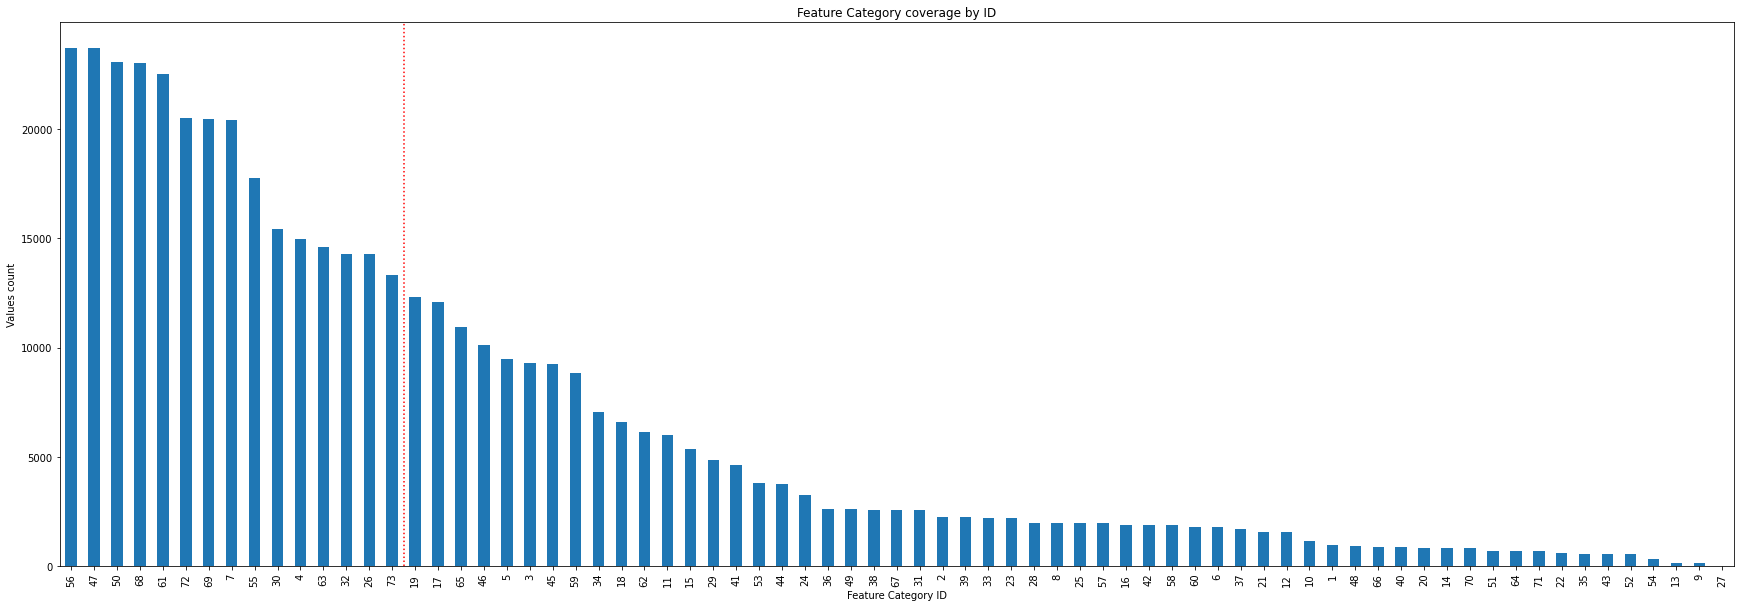

In [63]:
coverage = items['feature_category_id'].sort_values(ascending=False).value_counts(sort=True)
coverage.plot(
    kind='bar',
    figsize=(30, 10),
    xlabel='Feature Category ID',
    ylabel='Values count',
    title='Feature Category coverage by ID')
plt.axvline(x = 14.5, color='r', linestyle='dotted')

In [64]:
items = items[items['feature_category_id'].isin(list(coverage.index[:15]))]
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
2,2,68,351
4,2,72,75
7,2,50,76
8,2,61,462
...,...,...,...
471745,28143,72,371
471746,28143,68,351
471747,28143,55,390
471749,28143,73,91


In [65]:
coo_mat = sparse.coo_matrix((items["feature_value_id"], (items["item_id"], items["feature_category_id"])))
svd = TruncatedSVD(n_components)
embeddings_items = pd.DataFrame(svd.fit_transform(coo_mat))
del items, coo_mat, svd

df_sessions = train_sessions.sample(frac=0.10)
sessions_ranks = df_sessions.groupby('session_id').agg(rank=('item_id', 'count'))
df_sessions = df_sessions.join(sessions_ranks, on='session_id', rsuffix='_dup')
df_sessions = df_sessions[df_sessions['rank'] <= k]
df_sessions = df_sessions.drop(['date', 'rank'], axis=1) \
               .join(embeddings_items, on='item_id', rsuffix='_dup') \
               .set_index('session_id') \
               .sort_index()
columns = { f'<lambda_{i}>': i + 1 for i in range(k) }
components = [i for i in range(n_components)]
df_sessions = df_sessions.groupby('session_id')[components].agg([
    lambda x: x.iloc[0] if len(x) > 0 else 0.,
    lambda x: x.iloc[1] if len(x) > 1 else 0.,
    lambda x: x.iloc[2] if len(x) > 2 else 0.,
]).rename(columns=columns)
df_sessions.columns = df_sessions.columns.to_flat_index()
del train_sessions, sessions_ranks

train_purchases.drop('date', axis=1, inplace=True)
negative_samples = pd.concat([train_purchases.copy() for _ in range(4)]).reset_index(drop=True)
negative_samples['item_id'] = np.random.permutation(negative_samples['item_id'])
negative_samples['label'] = 0
positive_samples = train_purchases.copy()
positive_samples['label'] = 1
embedding_purchases = pd.concat([positive_samples, negative_samples]).reset_index(drop=True)
embedding_purchases = embedding_purchases.merge(embeddings_items, left_on='item_id', right_index=True)
embedding_purchases.drop('item_id', axis=1, inplace=True)
del train_purchases, negative_samples, positive_samples

df_merged = df_sessions.merge(embedding_purchases, on='session_id', how='inner')
df_merged.head()
X = df_merged.drop(['label', 'session_id'], axis=1)
y = df_merged['label']
X = X.reindex(columns = pd.Index([
        (0,1),(1,1),(2,1),(3,1),(4,1),(5,1),(6,1),(7,1),(8,1),(9,1),(10,1),(11,1),
        (0,2),(1,2),(2,2),(3,2),(4,2),(5,2),(6,2),(7,2),(8,2),(9,2),(10,2),(11,2),
        (0,3),(1,3),(2,3),(3,3),(4,3),(5,3),(6,3),(7,3),(8,3),(9,3),(10,3),(11,3),
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
    ]))
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [66]:
l_regr_v2 = LogisticRegression()
l_regr_v2.fit(X_train, y_train)
l_regr_v2.score(X_test, y_test)

0.7998465003666057

In [ ]:
input_shape = (k+1, 12)

rnn_v2 = Sequential()
rnn_v2.add(layers.Masking(mask_value=0, input_shape=input_shape))
rnn_v2.add(layers.LSTM(100,return_sequences=False))
rnn_v2.add(layers.Dense(k, activation='softmax'))

rnn_v2.compile("adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])
checkpoint = callbacks.ModelCheckpoint(filepath="model_checkpoint",
                                       monitor ="val_accuracy",
                                       save_best_only = True,
                                       mode='max')

history = rnn_v2.fit(X_train.values.reshape(-1, k+1, n_components),
                  y_train,
                  validation_split=0.2,
                  epochs=5,
                  batch_size=64,
                  callbacks=[checkpoint])
rnn_v2 = models.load_model('model_checkpoint')
rnn_v2.evaluate(X_test.values.reshape(-1, k+1, n_components), y_test)

# LeaderBoard

Here we can compute the prediction used for the leaderboard of RecSys challenge.

In [74]:
def compute_full_leaderboard(model, isKNN=False):
    rows = []
    leaderboard_sessions_dict = test_leaderboard_sessions.groupby('session_id')['item_id'].agg(list).to_dict()
    for session_id, session_items in tqdm(leaderboard_sessions_dict.items()):
        recommended_items = recommend_100_items(model, session_items[:k], isKNN)
        rows += [(session_id, item_id, i + 1) for i, item_id in enumerate(recommended_items)]
    res = pd.DataFrame(rows, columns=['session_id', 'item_id', 'rank'])
    res.to_csv('recsys_prediction.csv', index=False)

To reduce the complexity of the computation, we have only worked on the 150 most popular items in the `train_sessions` dataset.

In [75]:
train_sessions = pd.read_csv('data/train_sessions.csv', dtype={'session_id': int, 'item_id': int, 'date':object})

In [76]:
most_popular_items = list(train_sessions['item_id'] \
                .value_counts() \
                .reset_index() \
                .sort_values('item_id', ascending=False)['index'])[:150]

print(most_popular_items)
candidates = candidates[candidates['item_id'].isin(most_popular_items)]
print(candidates)

[8060, 26853, 2447, 1644, 19882, 7963, 8622, 17089, 11742, 18156, 23088, 2072, 4028, 20770, 9184, 21616, 19912, 6736, 26691, 7640, 17239, 27613, 21215, 18657, 2915, 24921, 4193, 1018, 20236, 27225, 12179, 2814, 8861, 27555, 972, 4130, 19150, 15501, 14392, 13922, 2173, 12251, 27151, 21890, 21668, 27852, 22704, 10390, 4917, 16660, 2855, 15140, 26301, 7792, 14550, 1368, 16922, 2098, 23451, 7999, 24243, 22607, 13409, 8755, 18981, 21152, 23789, 14306, 15249, 20629, 13596, 11565, 21781, 25415, 27556, 26249, 5367, 27442, 11053, 13081, 12959, 20028, 18723, 9427, 14927, 16064, 22747, 15738, 5704, 18801, 3774, 14378, 12540, 17740, 19227, 16218, 434, 15777, 1148, 28133, 2188, 17431, 10516, 22886, 21423, 26433, 8648, 17648, 9522, 19992, 6588, 19596, 26565, 11693, 12662, 18844, 7367, 23038, 13108, 4407, 107, 6256, 551, 6187, 26180, 1474, 13243, 2646, 23828, 15403, 12958, 2845, 18947, 24269, 26897, 14881, 25118, 3591, 773, 4528, 1515, 12842, 3233, 13226, 23450, 17362, 3373, 17429, 2410, 11378]
     

In [ ]:
compute_full_leaderboard(l_regr)